In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Developing a Temporal Model for Swimming Stroke Classification of IMU data 

## Data Exploration and Preprocessing

Cleaning up the labels for swimming strokes and phases and combining left and right data for freestyle and backstroke

In [45]:
# 8 stroke types/labels, combined L and R
label_mapping = {
    "00 breastroke": "breastroke",
    "01 butterfly": "butterfly",
    "02 backstroke L": "backstroke",
    "03 backstroke R": "backstroke",
    "04 freestyle L": "freestyle",
    "05 freestyle R": "freestyle",
    "06 flipturn": "flipturn",
    "07 open turn": "open turn",
    "08 pushoff": "pushoff",
    "09 startDive( .from a block)": "startDive(from a block)"
}

Add all the data files into a dataset where each entry is a pair of the IMU data and the coresponding swimming stroke/phase label

In [46]:
main_folder = r"C:\Users\zhaoez\Desktop\stroke classification business report\strokeanalysis - translated"
# stores the sensor data
data_list = []
# stores the coresponding label
label_list = []
# limit max timesteps as # of data in each file was inconsistent, standardizes the data
max_timesteps = 500

def preprocess(filepath):
    df = pd.read_csv(filepath)
    # removes the time entry as that will not be used to directly train models
    df.drop(columns=["hh:mm:ss.ms"], inplace=True, errors='ignore')
    # returns IMU sensor data as an array
    return df.values

# goes through all folders and files
for root, dirs, files in os.walk(main_folder):
    for dir in dirs:
        mapped_label = label_mapping.get(dir, dir)
        folder_path = os.path.join(root, dir)
        
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file.endswith(".csv"):
                # adds file data to the list after removing the time
                try:
                    sensor_data = preprocess(file_path)
                    data_list.append(sensor_data)
                    label_list.append(mapped_label)
                except Exception as e:
                    print(f"error processing {file_path}: {e}")

for i in data_list[:1]:
    print(i)
unique_label = list(set(label_list))
print(len(data_list))
print(unique_label)

[[ -53. -199.   19. ...  631. -412.   19.]
 [ -13. -205.   28. ...  631. -412.   19.]
 [  36. -210.   61. ...  651. -414.   21.]
 ...
 [-100. -171.  683. ...  675. -306.   27.]
 [ -92. -179.  700. ...  678. -307.   21.]
 [ -80. -191.  710. ...  678. -307.   21.]]
286
['butterfly', 'open turn', 'pushoff', 'freestyle', 'startDive(from a block)', 'breastroke', 'backstroke', 'flipturn']


### One-hot encoding by converting the stroke labels into numerical values

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [48]:
data_array = pad_sequences(data_list, maxlen=max_timesteps, dtype='float32', padding='post', truncating='post')
# encodes and classifies the labels as integers
labels = pd.factorize(np.array(label_list))[0]
# one-hot encoding for classification
labels_one_hot = to_categorical(labels)
print(labels_one_hot)
# number of data files for each stroketype/label
label_counts = pd.Series(label_list).value_counts()
print(label_counts)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
freestyle                  66
backstroke                 52
pushoff                    43
breastroke                 35
butterfly                  35
open turn                  23
flipturn                   16
startDive(from a block)    16
Name: count, dtype: int64


Visualize the distribution of data for each stroke/phase type to address possible class imbalance

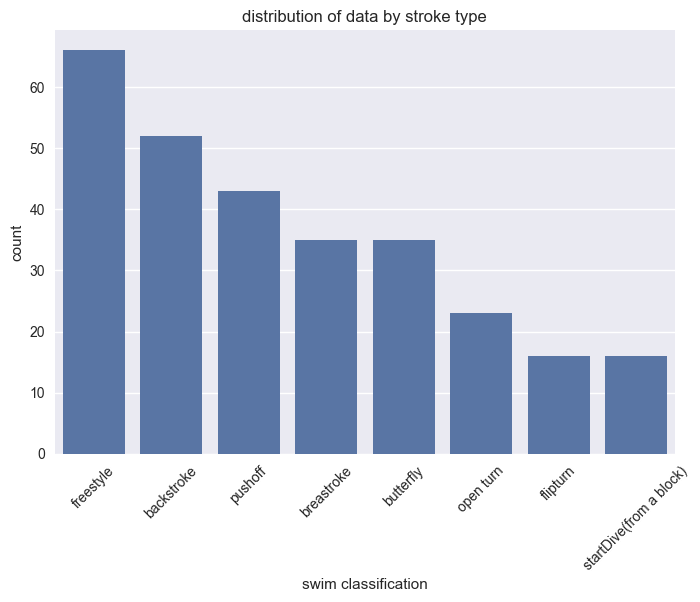

In [49]:
# bar plot for count of data for each stroke type
plt.figure()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("distribution of data by stroke type")
plt.xlabel("swim classification")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.show()

There is visible class imbalance as there are 66 instances of freestyle data and only 16 data for flipturns and startDive. In order to address this, class weights will be used to assign higher weights to the minority classes to reduce bias towards strokes and phases with more data.

Data is then reshaped from a 3D array to 2D array so that data visualizations can be easily visible and working in tabular format is easier to work with for statistical analysis. Column names were then created for the sensor data to enable feature selection and analysis later on.

In [50]:
# flattens into a 2D array where it goes from (data(286), timesteps(500), features(9)) to (data(286), timesteps*features)
data_df = pd.DataFrame(data_array.reshape(data_array.shape[0], -1))

# list of sensor features that will be the column
feature_columns = ['gyroX', 'gyroY', 'gyroZ', 'accX', 'accY', 'accZ', 'magX', 'magY', 'magZ']
feature_names = [f"{sensor}_{i+1}" for sensor in feature_columns for i in range(max_timesteps)]
data_df.columns = feature_names
data_df['label'] = label_list

# bar charts of the sensor values for each stroke type/phase to visibly see the distribution and determine if any strokes/phases have distinctive sensor patterns and if there are potential overlaps that might may be problematic for classification.

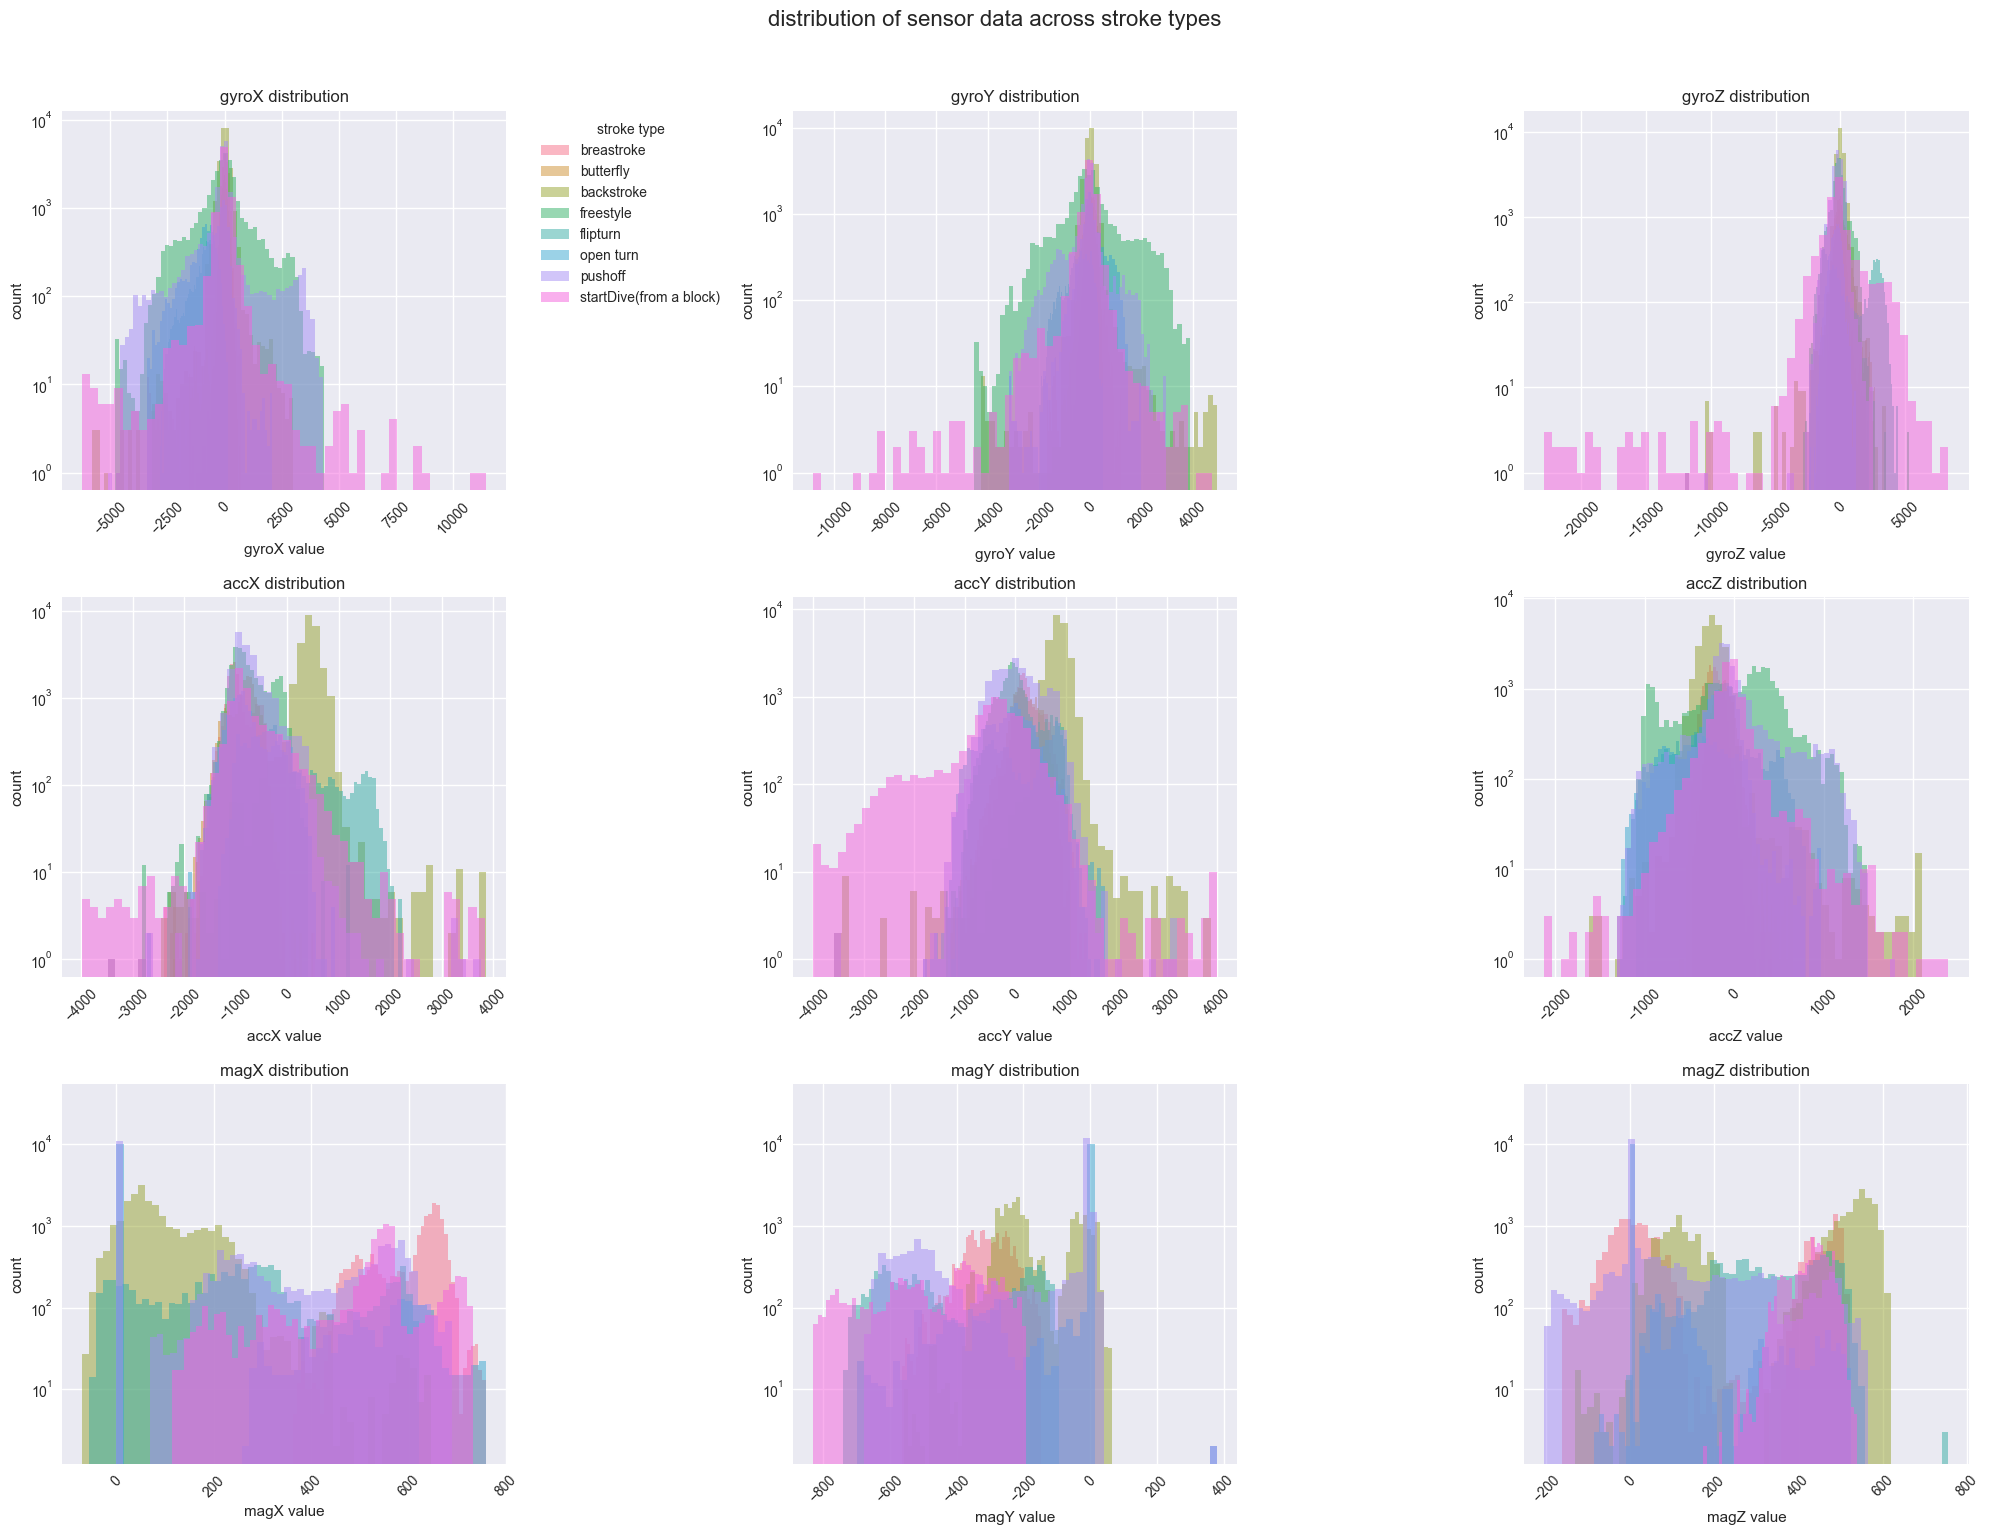

In [51]:
# plot style
plt.style.use('seaborn-v0_8')
n_sensors = len(feature_columns)
n_cols = 3
n_rows = (n_sensors + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle("distribution of sensor data across stroke types", fontsize=16, y=1.02)
axes = axes.flatten()
colors = sns.color_palette("husl", n_colors=len(pd.Series(label_list).unique()))

# bar plot for each sensor data
for idx, sensor in enumerate(feature_columns):
    sensor_idx = feature_columns.index(sensor)
    
    # plot for each stroke type
    for stroke_idx, stroke_type in enumerate(pd.Series(label_list).unique()):
        stroke_indices = [i for i, label in enumerate(label_list) if label == stroke_type]
        sensor_values = data_array[stroke_indices, :, sensor_idx].flatten()
        axes[idx].hist(sensor_values, 
                      bins=50,
                      alpha=0.5,
                      label=stroke_type,
                      color=colors[stroke_idx])
    
    axes[idx].set_title(f"{sensor} distribution")
    axes[idx].set_xlabel(f"{sensor} value")
    axes[idx].set_ylabel("count")
    
    if idx == 0:
        axes[idx].legend(title="stroke type", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[idx].get_legend().remove() if axes[idx].get_legend() else None

    # log y axis for smaller counts to be visible
    axes[idx].set_yscale('log')
    axes[idx].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

Some immediate observations that can be observed is that for a pushoff and open turn, the magX,Y,Z distribution seems to be majority 0 and in general, the strokes/phases have distinct distribution using mag data. Based on the distributions, we can expect mag < acc < gyro in terms of feature importance for our models due to the range of gyro.

Statistical analysis of the sensor data can provide some context and insights on the characterstics for each feature. A correlation matrix shows the relationship between the sensor data to check for redundancy but can also inform for feature selection.

sensor statistics:
  sensor        mean         std      min      max    range  zero_percentage
0  gyroX -135.636948  845.666992  -6233.0  11442.0  17675.0         0.346154
1  gyroY  -52.560673  727.667480 -10803.0   4948.0  15751.0         0.318182
2  gyroZ  -66.619141  794.943298 -22819.0   8325.0  31144.0         0.209091
3   accX -509.952271  619.747070  -3982.0   3864.0   7846.0         0.034965
4   accY  189.862930  561.648438  -3995.0   3997.0   7992.0         0.237063
5   accZ -135.645294  359.130463  -2120.0   2391.0   4511.0         0.189510
6   magX  172.448929  241.817215    -70.0    759.0    829.0        50.088112
7   magY -142.530884  192.820892   -829.0    381.0   1210.0        50.178322
8   magZ  145.495361  211.831879   -204.0    756.0    960.0        50.096503


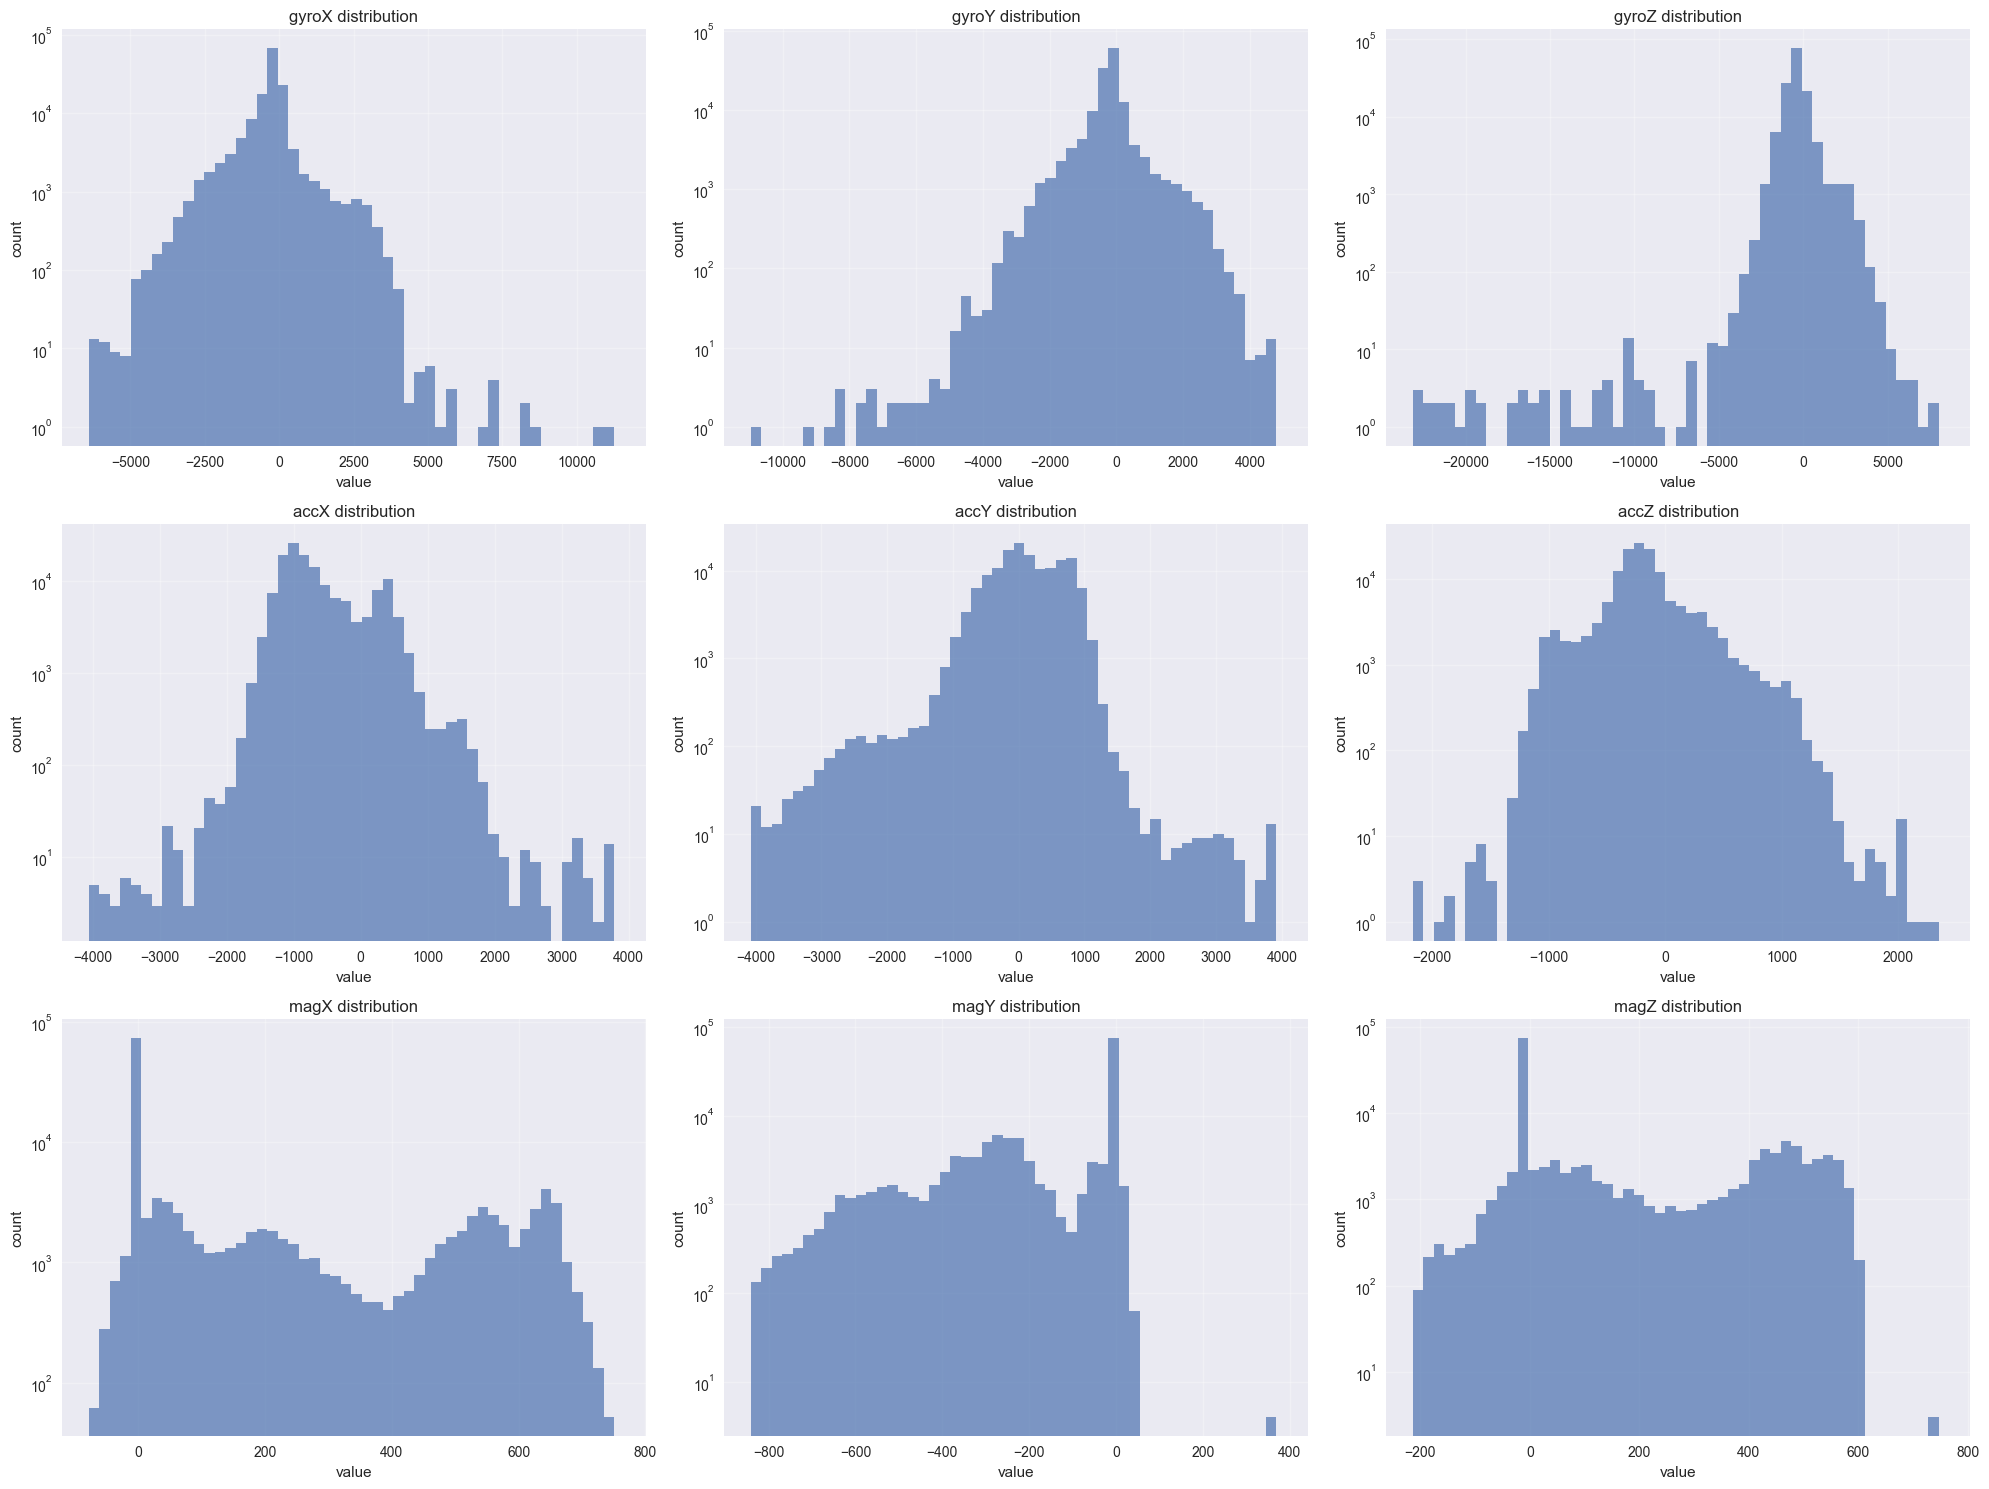

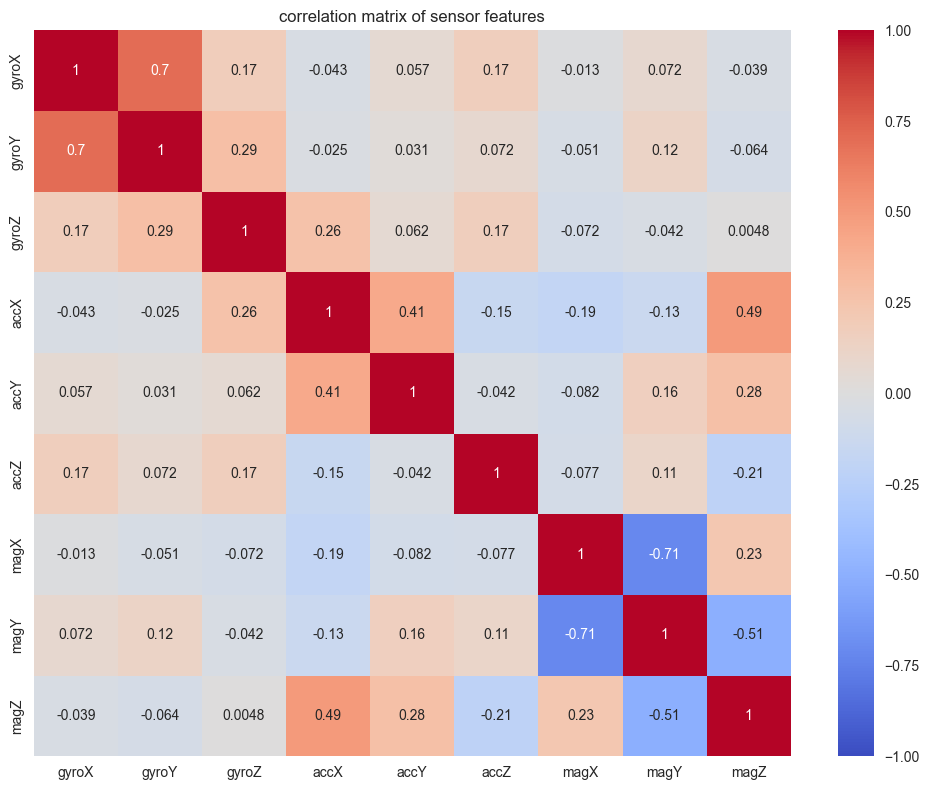

In [52]:
# calculates the mean, std, min/max, range, percentage of data that is 0 for each sensor data
feature_stats = []
for idx, sensor in enumerate(feature_columns):
    sensor_values = data_array[:, :, idx].flatten()
    stats = {
        'sensor': sensor,
        'mean': np.mean(sensor_values),
        'std': np.std(sensor_values),
        'min': np.min(sensor_values),
        'max': np.max(sensor_values),
        'range': np.max(sensor_values) - np.min(sensor_values),
        'zero_percentage': np.mean(sensor_values == 0) * 100
    }
    feature_stats.append(stats)

stats_df = pd.DataFrame(feature_stats)
print("sensor statistics:")
print(stats_df)

# bar plot for each sensor feature
plt.figure(figsize=(20, 15))
n_sensors = len(feature_columns)
n_cols = 3
n_rows = (n_sensors + n_cols - 1) // n_cols

for idx, sensor in enumerate(feature_columns):
    plt.subplot(n_rows, n_cols, idx + 1)
    sensor_values = data_array[:, :, idx].flatten()
    counts, bins, _ = plt.hist(sensor_values, bins=50, alpha=0)
    plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.7)
    
    plt.title(f"{sensor} distribution")
    plt.xlabel("value")
    plt.ylabel("count")
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

plt.tight_layout()
plt.show()

# correlation matrix of the sensor values
reshaped_data = data_array.reshape(-1, 9)
correlation_matrix = np.corrcoef(reshaped_data.T)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            xticklabels=feature_columns,
            yticklabels=feature_columns,
            annot=True, 
            cmap='coolwarm',
            vmin=-1, 
            vmax=1,
            center=0)
plt.title("correlation matrix of sensor features")
plt.tight_layout()
plt.show()

Based on the statistical and data analysis, gyroscope data has  the largest range which aligns with the knowledge that certain strokes and motions rely on rotation more than others (freestyle vs breastroke). While  the accelerometer provides consistent readings with minimal dead zones, the magnetometer's high zero percentage might indicate it's less reliable for stroke classification which logically is sound as there should be limited change in the magnetic field for the swimmer.

Varying levels of correlation between the axes shown in the correlation matrix indicates that we are dealing with complex, multi-dimensional swimming movements and data which can infleunce classification decisions.

## Data Preparation

In [53]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# 80:20 data split, reproducibility
X_train, X_test, y_train, y_test = train_test_split(data_array, labels_one_hot, test_size=0.2, random_state=42)
# check shapes of data arrays (sanity)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (228, 500, 9)
y_train shape: (228, 8)


Prepare data for PCA by flattening the data into 2D for PCA and standardize the the features to zero mean and variance. PCA is a dimensionality reduction techinque that helps reduce overfitting by removing noisy features while retaining as much of the original data. An associated scree and cumulative variance plot was graphed to show the explained variance ratio for each component and the total explained variance as components are added respectively. A 90% variance threshold was decided upon as it can capture more variance in the dataset compared to the standard 80% threshold and given the limited data, it is not computationally heavy.

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

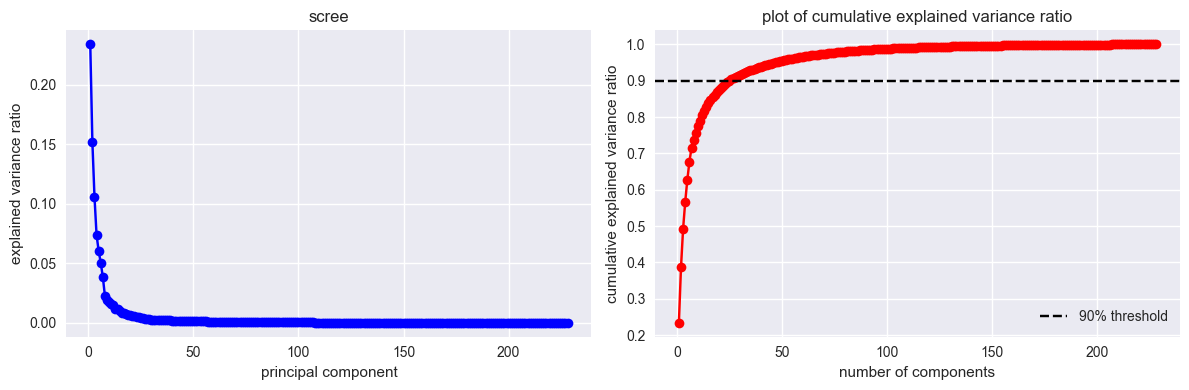


components needed for 90% variance: 26
original data shape: (228, 500, 9)
PCA transformed data shape: (228, 26)


In [55]:
# 3-D -> 2D for PCA
X_flat_train = X_train.reshape(X_train.shape[0], -1)
# standardize features
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_flat_train)
# PCA
pca = PCA()
X_pca_train = pca.fit_transform(X_scaled_train)
# explained variance ratio = eigenvalue / sum of all eigenvalues
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# scree
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.title('scree')
plt.xlabel('principal component')
plt.ylabel('explained variance ratio')
plt.grid(True)

# cumulative explained variance 
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-')
plt.axhline(y=0.90, color='k', linestyle='--', label='90% threshold')
plt.title('plot of cumulative explained variance ratio')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance ratio')
plt.legend()
plt.tight_layout()
plt.show()

X_flat_test = X_test.reshape(X_test.shape[0], -1)
X_scaled_test = scaler.transform(X_flat_test)
X_pca_test = pca.transform(X_scaled_test)

n_components_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
print(f"\ncomponents needed for 90% variance: {n_components_90}")
# PCA for the number of components needed for 90%
# 26 PC <=> sum of first 26 eigenvalues is 90%
pca_final = PCA(n_components=n_components_90)
X_train_pca = pca_final.fit_transform(X_scaled_train)
X_test_pca = pca_final.transform(X_scaled_test)
print(f"original data shape: {X_train.shape}")
print(f"PCA transformed data shape: {X_train_pca.shape}")

With 9 sensor data features (gyroX, gyroY, gyroZ, accX, accY, accZ, magX, magY, magZ) and 500 timestamps per data file, it was a 4500 dimensional space which can easily lead to overfitting so PCA will help reduce thedimensionality based on whichever component captures the most variance. A loading analysis was also done to analyze the contributions of original features to principal components. From the scree plot, past approxi0mately 25 pcs, components will contribute to nearly 0% explained variance and indeed with the coresponding graph it is shown that around 25 pcs represent 90% of the explained variance. This meant that there were redundancy in the IMU data that should be compressed to increase computational efficiency.

Class weights were also caluclated after PCA only on the training data and bar plots are used to represent the updated class weights where higher class weights were for stroke types/phases where there was less data.

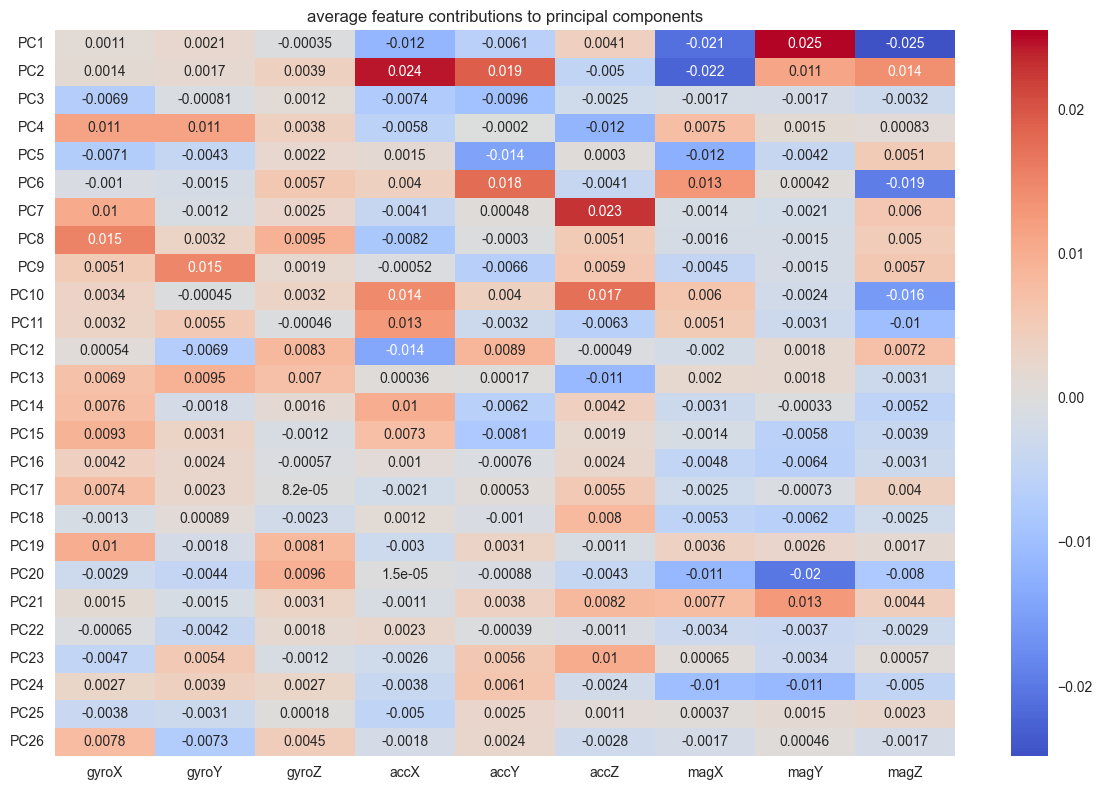


class weights:
class 0: 1.017857
class 1: 0.982759
class 2: 0.678571
class 3: 0.518182
class 4: 2.375000
class 5: 1.781250
class 6: 0.863636
class 7: 2.192308


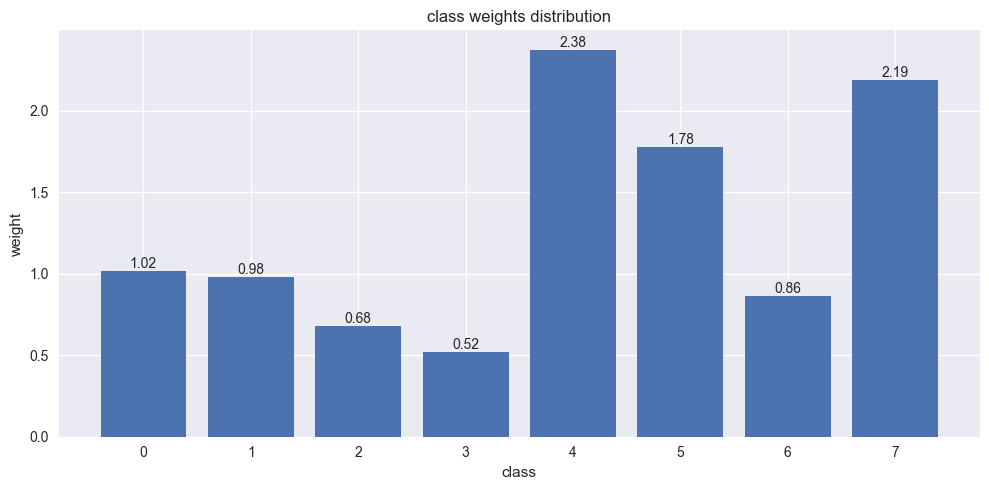

In [56]:
# loadings vs eigen values: eigen are the variance explained by PC while loadings are contributions
# contribution of original variables to principal component
loadings = pca_final.components_
# 9 sensors from IMU
n_features = X_train.shape[2]
# 500 timesteps
n_timesteps = X_train.shape[1]
sensor_loadings = loadings.reshape(n_components_90, n_timesteps, n_features)
avg_sensor_loadings = np.mean(sensor_loadings, axis=1)

# plot for loadings
plt.figure(figsize=(12, 8))
sns.heatmap(avg_sensor_loadings, 
            xticklabels=['gyroX', 'gyroY', 'gyroZ', 'accX', 'accY', 'accZ', 'magX', 'magY', 'magZ'],
            yticklabels=[f'PC{i+1}' for i in range(n_components_90)],
            cmap='coolwarm', center=0, annot=True)
plt.title('average feature contributions to principal components')
plt.tight_layout()
plt.show()

y_train_labels = np.argmax(y_train, axis=1)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_train_labels), 
                                   y=y_train_labels)
class_weight_dict = dict(zip(np.unique(y_train_labels), class_weights))
print("\nclass weights:")
for class_label, weight in class_weight_dict.items():
    print(f"class {class_label}: {weight:.6f}")
    
plt.figure(figsize=(10, 5))
class_labels = list(class_weight_dict.keys())
weights = list(class_weight_dict.values())

plt.bar(class_labels, weights)
plt.title("class weights distribution")
plt.xlabel("class")
plt.ylabel("weight")

for i, weight in enumerate(weights):
    plt.text(i, weight, f'{weight:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

According to the feature contribution, the first principal component is heavily influenced by magnetic sensors (magX, magY, magZ) with contributions around ±0.02-0.025 and PC2 shows strong contributions from accelerometer data (accX, accY) with values around 0.02. Information is distributed across all sensors which justifies the use of tracking various sensor data.

After applying class weights to address class imbalance, freestyle and backstroke now have the least weight since they were overrepresented in the original dataset while flip turn and dives were underrepresented. Now, there is more importance in the underrepresented class and reduced the influence of overrepresented class.

### When working with an imbalanced dataset, using stratified k-fold cross-validation maintains class proportions within each fold. 

In [57]:
# cross validation for non-temporal models
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_test_labels = np.argmax(y_test, axis=1)
X_train_balanced = X_train_pca
y_train_balanced = y_train_labels

## Model Training

### Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_pca)

In [60]:
# logistic regression
# multi-class classification
lr = LogisticRegression(max_iter=1000, C=0.001, 
                       class_weight=class_weight_dict)
lr.fit(X_train_scaled, y_train_balanced)
lr_train_pred = lr.predict(X_train_scaled)
lr_test_pred = lr.predict(X_test_scaled)
print("\nlr training:")
print(classification_report(y_train_balanced, lr_train_pred, digits=6))


lr training:
              precision    recall  f1-score   support

           0   0.933333  1.000000  0.965517        28
           1   0.906250  1.000000  0.950820        29
           2   0.976744  1.000000  0.988235        42
           3   1.000000  0.872727  0.932039        55
           4   1.000000  1.000000  1.000000        12
           5   0.882353  0.937500  0.909091        16
           6   0.909091  0.909091  0.909091        33
           7   1.000000  1.000000  1.000000        13

    accuracy                       0.951754       228
   macro avg   0.950971  0.964915  0.956849       228
weighted avg   0.954191  0.951754  0.951411       228



Logistic regression is a great starting point as it is easily interpretable because and an easy algorithm to implement. For the training data, there seems to be overfitting occurring in classes where there are limited amounts of data (4 and 7).


### Random Forest w/RandomizedSearchCV

Training a random forest classifier with hyperparameter tuning and selecting the best model based on CV

In [61]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier

In [62]:
param_dist = {
    # ways to increase regularization to avoid overfitting
    'n_estimators': randint(200, 400),  # increase trees 
    'max_depth': randint(3, 6),  # reduce max depth
    'min_samples_split': randint(30, 50),  # increase split threshold
    'min_samples_leaf': randint(10, 25),  # increase leaf size
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': randint(15, 30),  # reduce max leaves
    'min_impurity_decrease': uniform(0.0001, 0.01),  # require meaningful splits
    'bootstrap': [True]  # keep bootstrap for better generalization
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, 
                          class_weight=class_weight_dict,
                          oob_score=True),  # enable out-of-bag score
    param_distributions=param_dist,
    n_iter=100,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

rf_random.fit(X_train_balanced, y_train_balanced)
print("\nbest param:")
print(rf_random.best_params_)
print("\ncv score:", rf_random.best_score_)

best_rf = rf_random.best_estimator_
rf_train_pred = best_rf.predict(X_train_balanced)
rf_test_pred = best_rf.predict(X_test_pca)

print("\nrf training:")
print(classification_report(y_train_balanced, rf_train_pred, digits=6))


best param:
{'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': 22, 'min_impurity_decrease': 0.0068716834238298176, 'min_samples_leaf': 12, 'min_samples_split': 30, 'n_estimators': 360}

cv score: 0.9308392415562515

rf training:
              precision    recall  f1-score   support

           0   0.933333  1.000000  0.965517        28
           1   0.966667  1.000000  0.983051        29
           2   1.000000  1.000000  1.000000        42
           3   1.000000  0.872727  0.932039        55
           4   1.000000  1.000000  1.000000        12
           5   0.833333  0.937500  0.882353        16
           6   0.914286  0.969697  0.941176        33
           7   1.000000  1.000000  1.000000        13

    accuracy                       0.960526       228
   macro avg   0.955952  0.972491  0.963017       228
weighted avg   0.963471  0.960526  0.960445       228



Used RandomizedSearchCV instead of GridSearchCV because it is more efficient for larger parameter spaces. Initially, RF was overfitting to the training data so more agressive regularization was applied for the parameters.



### XGBoost

In [63]:
from xgboost import XGBClassifier

shallow tree to prevent overfitting, l1 and l2 regularization

In [64]:
# xgb

#old xgb without early stopping
'''
xgb = XGBClassifier(random_state=42, max_depth=4,
                    min_child_weight=7,
                    reg_alpha=0.5,
                    reg_lambda=2)
xgb.fit(X_train_balanced, y_train_balanced)
xgb_train_pred = xgb.predict(X_train_balanced)
xgb_test_pred = xgb.predict(X_test_pca)
print("\nxgb training:")
print(classification_report(y_train_balanced, xgb_train_pred, digits=6))
'''
# need to split training data for validation for early stopping
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train_balanced, y_train_balanced, 
    test_size=0.2, 
    random_state=42
)

xgb = XGBClassifier(
    random_state=42, 
    max_depth=3, # shallow trees 
    min_child_weight=10,
    reg_alpha=1, # l1
    reg_lambda=5, #l2
    # stop if no improvement for 5 rounds
    early_stopping_rounds=5
)

# fit with validaiton data
xgb.fit(
    X_train_xgb, 
    y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False
)

xgb_train_pred = xgb.predict(X_train_balanced)
xgb_test_pred = xgb.predict(X_test_pca)
print("\nxgb training:")
print(classification_report(y_train_balanced, xgb_train_pred, digits=6))


xgb training:
              precision    recall  f1-score   support

           0   0.964286  0.964286  0.964286        28
           1   0.906250  1.000000  0.950820        29
           2   1.000000  1.000000  1.000000        42
           3   0.947368  0.981818  0.964286        55
           4   1.000000  0.833333  0.909091        12
           5   1.000000  0.812500  0.896552        16
           6   0.941176  0.969697  0.955224        33
           7   1.000000  0.923077  0.960000        13

    accuracy                       0.960526       228
   macro avg   0.969885  0.935589  0.950032       228
weighted avg   0.962480  0.960526  0.959938       228



Further split the training set into training and validation sets for early stopping to prevent overfitting where the validation set will serve as a proxy for unseen data.

### CNN-LSTM Hybrid Model

CNN is used for its capabilities at extracting local patterns from the IMU data while LSTM captures the temporal dependencies in the sequences.

In [65]:
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow import keras
from keras_tuner import RandomSearch

In [66]:
# optimizer for temporal model
optimizer = keras.optimizers.Adam(
    learning_rate=1e-3,  # default learning rate
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

# temporal model
# hyperparameter tuning
def build_model(hp):
    '''
    Hybrid CNN and LSTM DL model for time series classification
    1-2 CNN layers (2nd optional)
    2 LSTM layers
    1-2 Dense layers (2nd optional)
    Final layer
    '''
    # input layer
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = inputs
    
    # CNN layers
    x = Conv1D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Int('conv1_kernel', min_value=2, max_value=5),
        activation='relu'
    )(x)
    x = MaxPooling1D(
        pool_size=hp.Int('pool1_size', min_value=2, max_value=4)
    )(x)
    x = BatchNormalization()(x)
    
    # 2nd CNN layer
    if hp.Boolean('add_conv_layer'):
        x = Conv1D(
            filters=hp.Int('conv2_filters', min_value=16, max_value=64, step=16),
            kernel_size=hp.Int('conv2_kernel', min_value=2, max_value=5),
            activation='relu'
        )(x)
        x = MaxPooling1D(
            pool_size=hp.Int('pool2_size', min_value=2, max_value=4)
        )(x)
        x = BatchNormalization()(x)
    
    # LSTM layers
    x = LSTM(
        units=hp.Int('lstm1_units', min_value=32, max_value=128, step=32),
        return_sequences=True
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1))(x)
    
    x = LSTM(
        units=hp.Int('lstm2_units', min_value=16, max_value=64, step=16)
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1))(x)
    
    # dense layers
    x = Dense(
        units=hp.Int('dense1_units', min_value=16, max_value=64, step=16),
        activation='relu'
    )(x)
    
    if hp.Boolean('add_dense_layer'):
        x = Dense(
            units=hp.Int('dense2_units', min_value=8, max_value=32, step=8),
            activation='relu'
        )(x)
    
    # output layer
    outputs = Dense(8, activation='softmax')(x)

    optimizer = keras.optimizers.Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    )
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Model Architecture Design

For CNN layers, the first layer is required and has a flexible number of filters to find the optimal feature extraction and different kernel sizes to capture the temporal patterns. The optional second layer is there for complex feature extraction.
There are 32-128 filters as the minimum ensures sufficient feature detectors while the maximum ensures complex patterns can be captured. The step size of 32 makes sure that the intervals are balanced.
Kernels of range 2-5 are implemented since smaller kernels can capture detailed patterns while larger kernels capture broader patterns and this range allows for flexibility.
Including an optional layer will allow the model to adapt to data complexity and using fewer filters (16-64) would be better as higher-level features are more abstract. The kernel size range remains the same since we want to keep the pattern detection to be consistent for both layers.

For LSTM, two layers are implemented for hierarchical temporal feature learning where the first LSTM will return sequences for the second LSTM. While the first layer processes the raw IMU sequences, the second layer will then learn the higher-level temporal patterns.
The number of units from the first to second layer is decreased from 128 to 64 to create the bottleneck architecture.

BatchNormalization will help stabilize training by normalizing the layer inputs and allows for higher learning rates.
Dropout will prevent overfitting with a range of 0.1-0.5 to prevent extreme dropouts. 

Both are applied to CNN and LSTM layers.

A second dense layer is included for flexibility purposes and the number of units is decreased for gradual dimentionality reduction. ReLU activation is also included for non-linearity and gradient flow.

For the optimizer, the minimum learning rate is slow enough for convergence while the maximum is fast for efficient training. I chose to use the Adam optimizer as it is adaptive.

In [67]:
X_temporal = data_array.reshape(data_array.shape[0], -1, 9)
X_train_temporal, X_test_temporal, y_train_temporal, y_test_temporal = train_test_split(
    X_temporal, labels_one_hot, test_size=0.2, random_state=42
)
y_train_temporal_labels = np.argmax(y_train_temporal, axis=1)
temporal_class_weights = compute_class_weight('balanced', 
                                            classes=np.unique(y_train_temporal_labels), 
                                            y=y_train_temporal_labels)
temporal_class_weight_dict = dict(zip(np.unique(y_train_temporal_labels), temporal_class_weights))

Data is then reshaped to samples, timesteps, and features for temporal processing while preserving the time series of the IMU data.

In [68]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    # change to lower value 
    max_trials=20,
    directory='keras_tuner',
    project_name='cnn_lstm_tuning'
)

Reloading Tuner from keras_tuner\cnn_lstm_tuning\tuner0.json


Hyperparameter tuning with RandomSearch for optimizaiton and running 20 trials for computational efficiency and this should optimize for validation accuracy.

In [69]:
# early stop
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Early stopping to prevent overfitting and restores the best weights automatically while using the class weights to address class imbalance

In [70]:
import tensorflow as tf

In [71]:
# hyperparameter search
tuner.search(
    X_train_temporal,
    y_train_temporal,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=temporal_class_weight_dict
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tf.random.set_seed(42)
best_model = build_model(best_hps)

history = best_model.fit(
    X_train_temporal,
    y_train_temporal,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=temporal_class_weight_dict,
    verbose=0
)

C:\Users\zhaoez\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Model Evaluation

In [72]:
print("\nbest hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")
print("\nnon-temporal models:")
print("\nlogistic regression:")
print(classification_report(y_test_labels, lr.predict(X_test_scaled), digits=6, zero_division=0))
print("\nrandom forest:")
print(classification_report(y_test_labels, rf_random.predict(X_test_pca), digits=6, zero_division=0))
print("\nXGBoost:")
print(classification_report(y_test_labels, xgb.predict(X_test_pca), digits=6, zero_division=0))
print("\nCNN-LMST hybrid w/hyperparameter tuning:")
@tf.function(reduce_retracing=True)
def predict_fn(model, data):
    return model(data, training=False)

def make_predictions(model, data):
    predictions = []
    batch_size = 32
    data = tf.convert_to_tensor(data, dtype=tf.float32)
    
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        pred = predict_fn(model, batch)
        predictions.append(pred)
    
    return tf.concat(predictions, axis=0)

test_pred = make_predictions(best_model, X_test_temporal)
test_pred = test_pred.numpy()
print(classification_report(y_test_temporal.argmax(axis=1), test_pred.argmax(axis=1), digits=6, zero_division=0))


best hyperparameters:
conv1_filters: 64
conv1_kernel: 3
pool1_size: 2
add_conv_layer: True
lstm1_units: 32
dropout1: 0.5
lstm2_units: 16
dropout2: 0.30000000000000004
dense1_units: 64
add_dense_layer: True
learning_rate: 0.005796367255408768
dense2_units: 32
conv2_filters: 48
conv2_kernel: 2
pool2_size: 4

non-temporal models:

logistic regression:
              precision    recall  f1-score   support

           0   0.875000  1.000000  0.933333         7
           1   1.000000  0.833333  0.909091         6
           2   0.833333  1.000000  0.909091        10
           3   0.888889  0.727273  0.800000        11
           4   1.000000  1.000000  1.000000         4
           5   0.777778  1.000000  0.875000         7
           6   0.875000  0.700000  0.777778        10
           7   1.000000  1.000000  1.000000         3

    accuracy                       0.879310        58
   macro avg   0.906250  0.907576  0.900537        58
weighted avg   0.886734  0.879310  0.875544        5

### Feature Importance

In [73]:
# statistical summary of feature importance
rf_importance_pairs = []
feature_names = ['gyroX', 'gyroY', 'gyroZ', 'accX', 'accY', 'accZ', 'magX', 'magY', 'magZ']
for name, importance in zip(feature_names, best_rf.feature_importances_):
    rf_importance_pairs.append((name, importance))

sorted_importance = sorted(rf_importance_pairs, key=lambda x: x[1], reverse=True)

print("\nrandom forest feature importance:")
for sensor, importance in sorted_importance:
    print(f"{sensor}: {importance:.6f}")


random forest feature importance:
gyroY: 0.150555
gyroX: 0.114774
accZ: 0.102071
accX: 0.101100
gyroZ: 0.095178
accY: 0.086443
magY: 0.055196
magX: 0.054802
magZ: 0.024490


From the performing model (rf), these are the most important features for classification according to the model. In general, the gyro data contributed to a large portion of the predictive power while mag contributed the least overall.

## Confusion Matrix

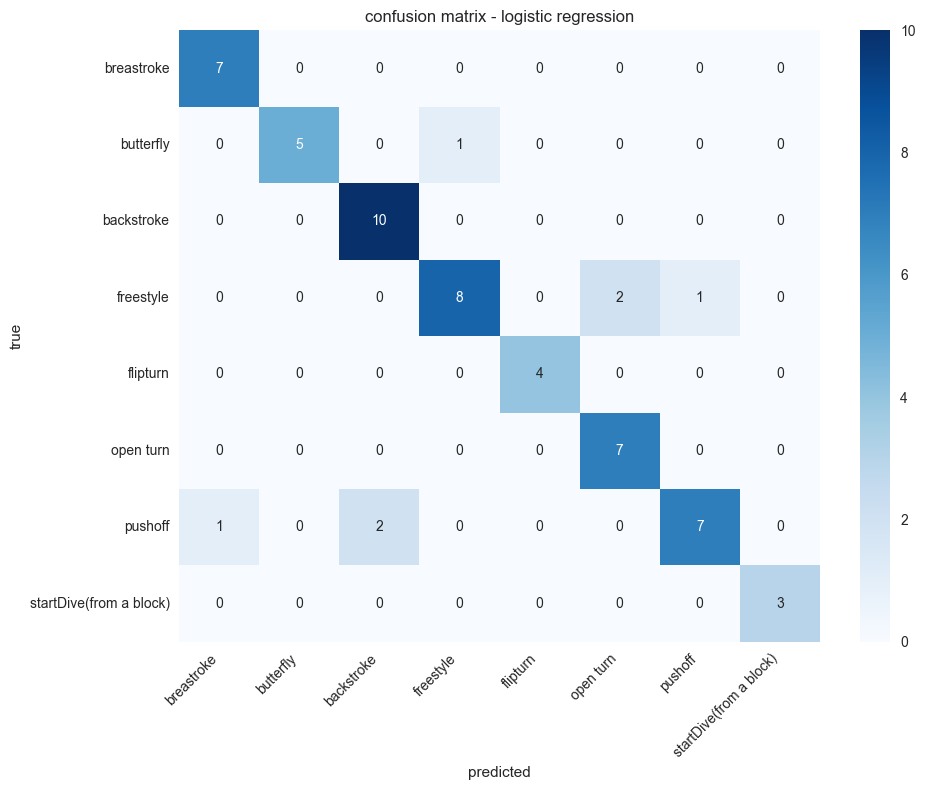

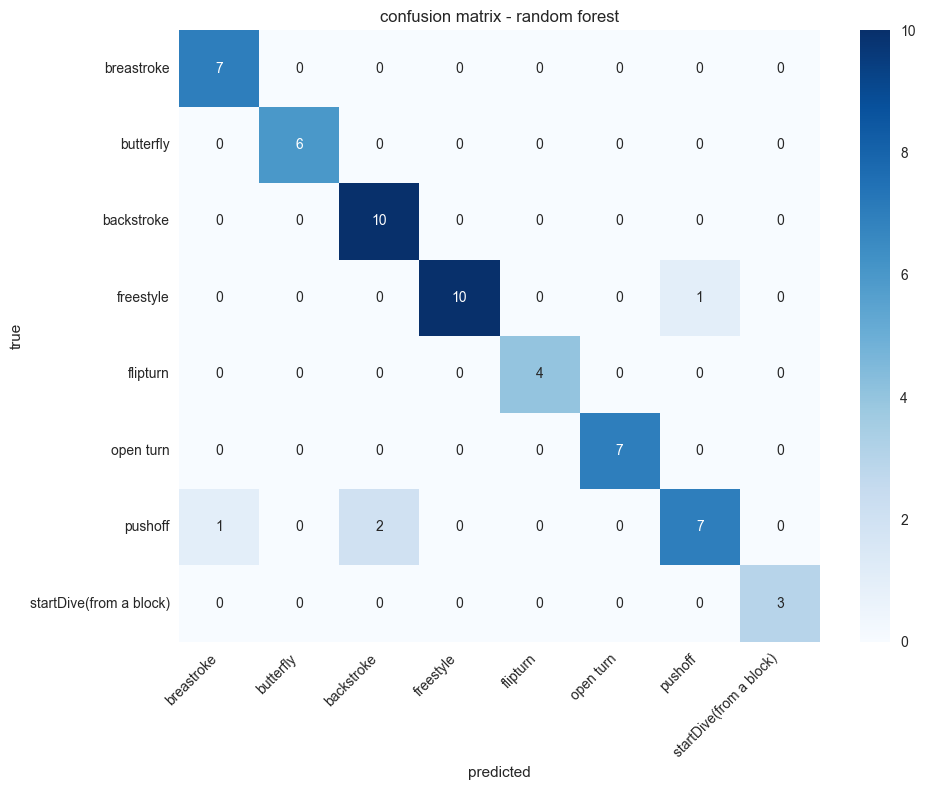

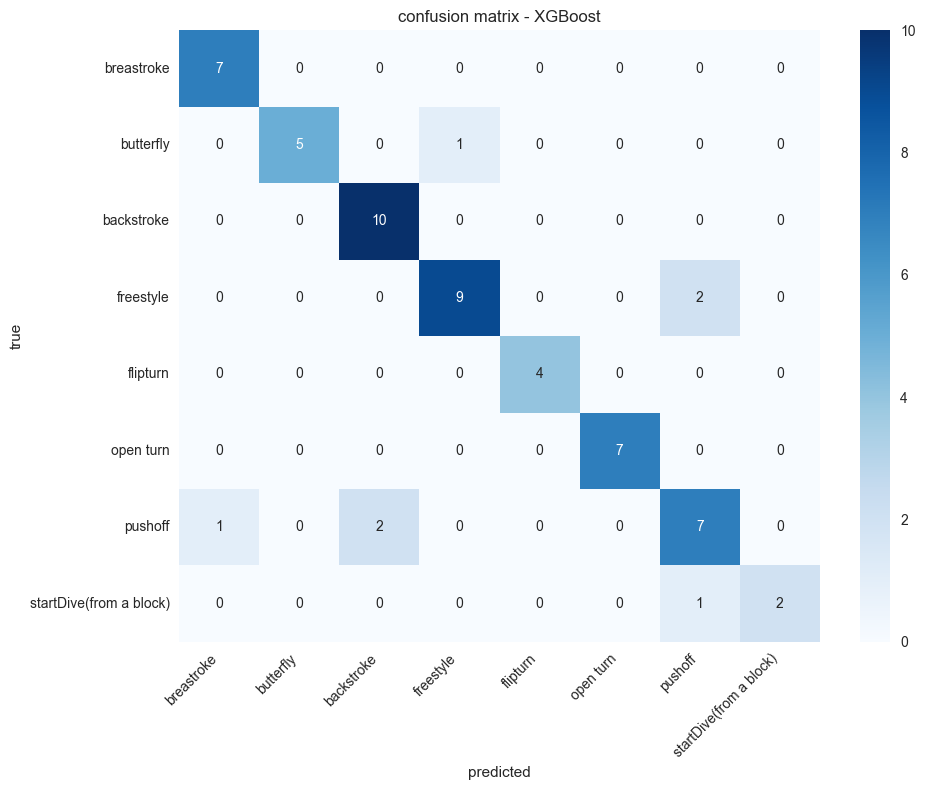

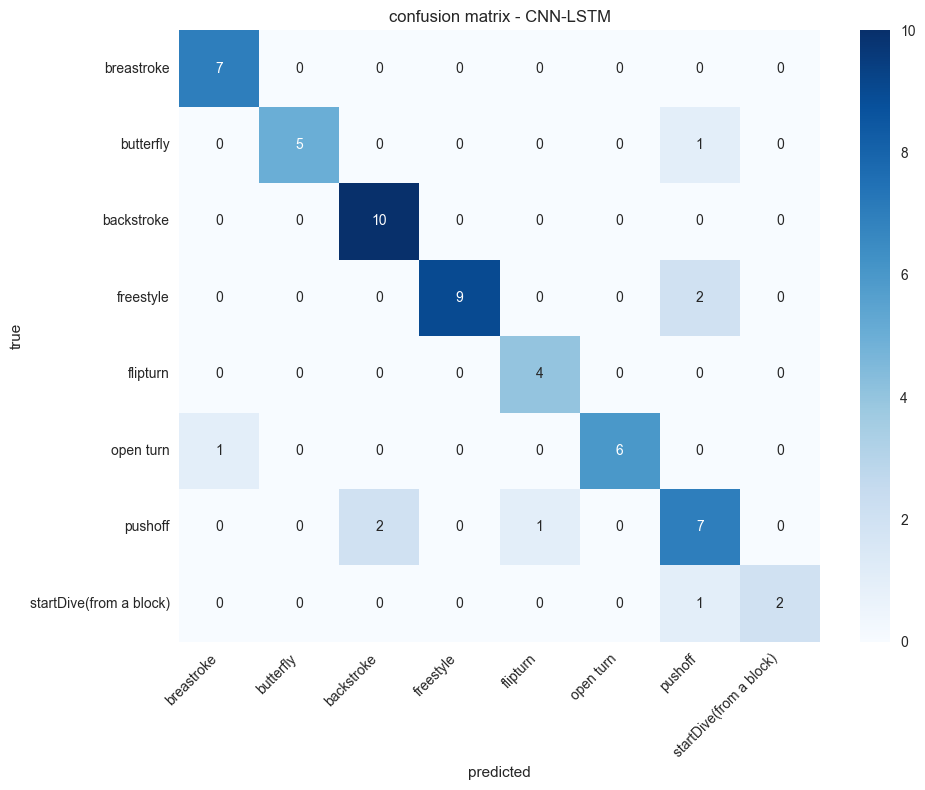

In [74]:
# confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    stroke_types = list(dict.fromkeys(label_mapping.values()))
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0] > len(stroke_types):
        backstroke_indices = [i for i, label in enumerate(label_mapping.values()) 
                            if label == 'backstroke']
        freestyle_indices = [i for i, label in enumerate(label_mapping.values()) 
                           if label == 'freestyle']
        
        if len(backstroke_indices) > 1:
            cm[backstroke_indices[0]] += cm[backstroke_indices[1]]
            cm = np.delete(cm, backstroke_indices[1], axis=0)
            cm[:, backstroke_indices[0]] += cm[:, backstroke_indices[1]]
            cm = np.delete(cm, backstroke_indices[1], axis=1)
        
        if len(freestyle_indices) > 1:
            cm[freestyle_indices[0]] += cm[freestyle_indices[1]]
            cm = np.delete(cm, freestyle_indices[1], axis=0)
            cm[:, freestyle_indices[0]] += cm[:, freestyle_indices[1]]
            cm = np.delete(cm, freestyle_indices[1], axis=1)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=stroke_types,
                yticklabels=stroke_types)
    plt.title(f'confusion matrix - {model_name}')
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test_labels, lr_test_pred, 'logistic regression')
plot_confusion_matrix(y_test_labels, rf_test_pred, 'random forest')
plot_confusion_matrix(y_test_labels, xgb_test_pred, 'XGBoost')
plot_confusion_matrix(y_test_temporal.argmax(axis=1), test_pred.argmax(axis=1), 'CNN-LSTM')

Examining the confusion matrix for each model, all the models performed well as shown with their diagonal performance that indicates the prediction matched the true classification. XGBoost made the most misclassifications at 7 while random forest made the least amount of mistakes at 4. Across the board, freestyle and backstroke were well-classified followed by breastroke and butterfly. However, the transitional phases of pushoff and turns showed the most confusion. An explanation for this is that the IMU data may end up capturing the swimmer going from the transition movement into a stroke and the data is not fully partitioned for this.

## Learning Curve for CNN-LSTM

In [75]:
from sklearn.metrics import roc_curve, auc

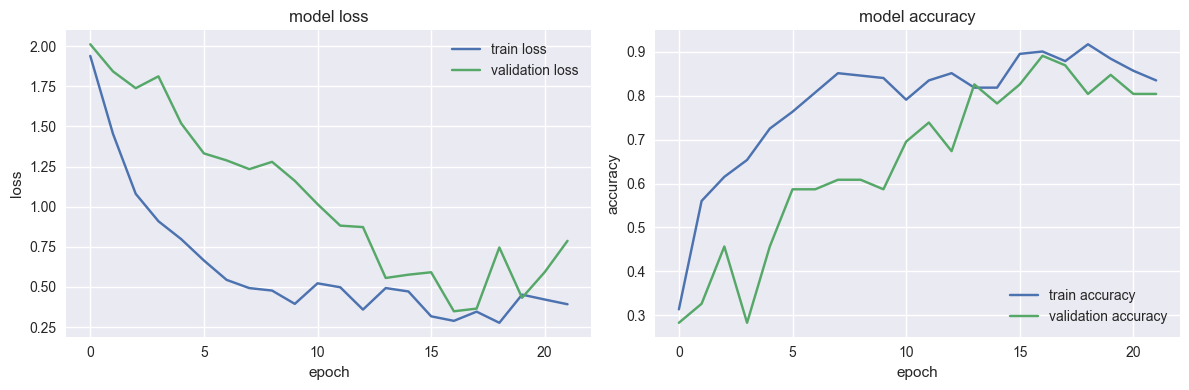

In [76]:
# learning curve for CNN-LSTM
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.tight_layout()
plt.show()

The best CNN-LSTM model loss and accuracy decreases and increases respectively when epoch is increased. Unfortunately, the validation loss is higher than the training loss until the later epochs and vice versa for accuracy so overfitting is occurring and not generalizing well. This is sort of expected as there is limited available IMU data to train a deep learning model where a simpler model may suffice.

## ROC-AUC Evaluation

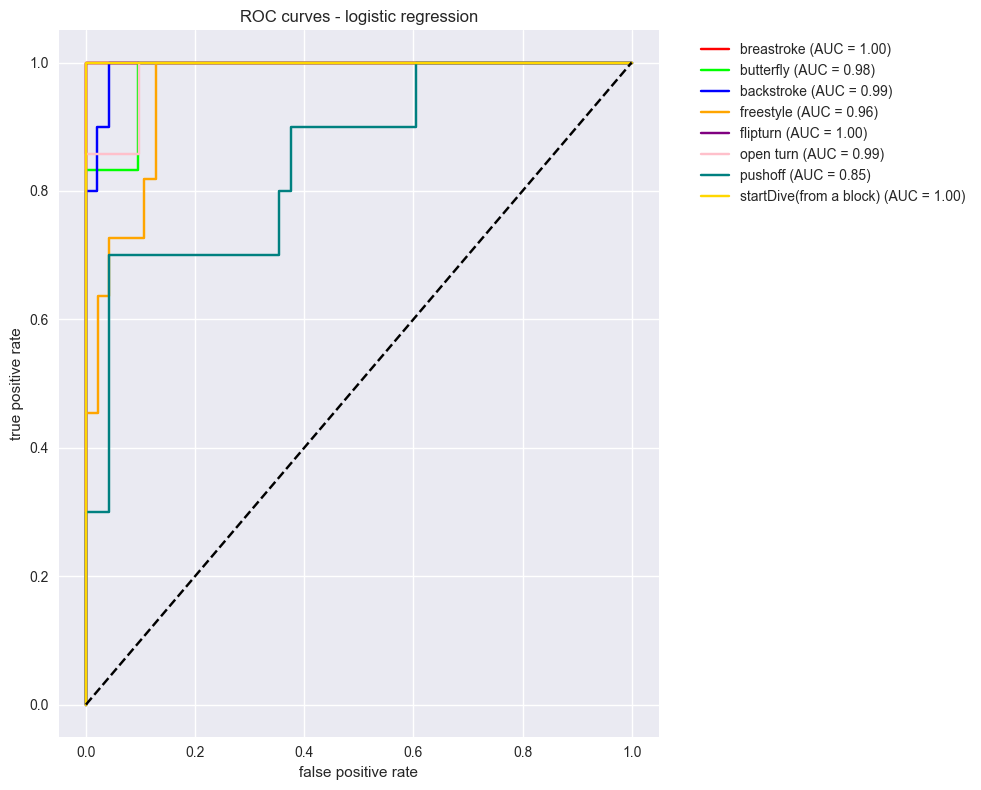


average AUC for logistic regression: 0.972


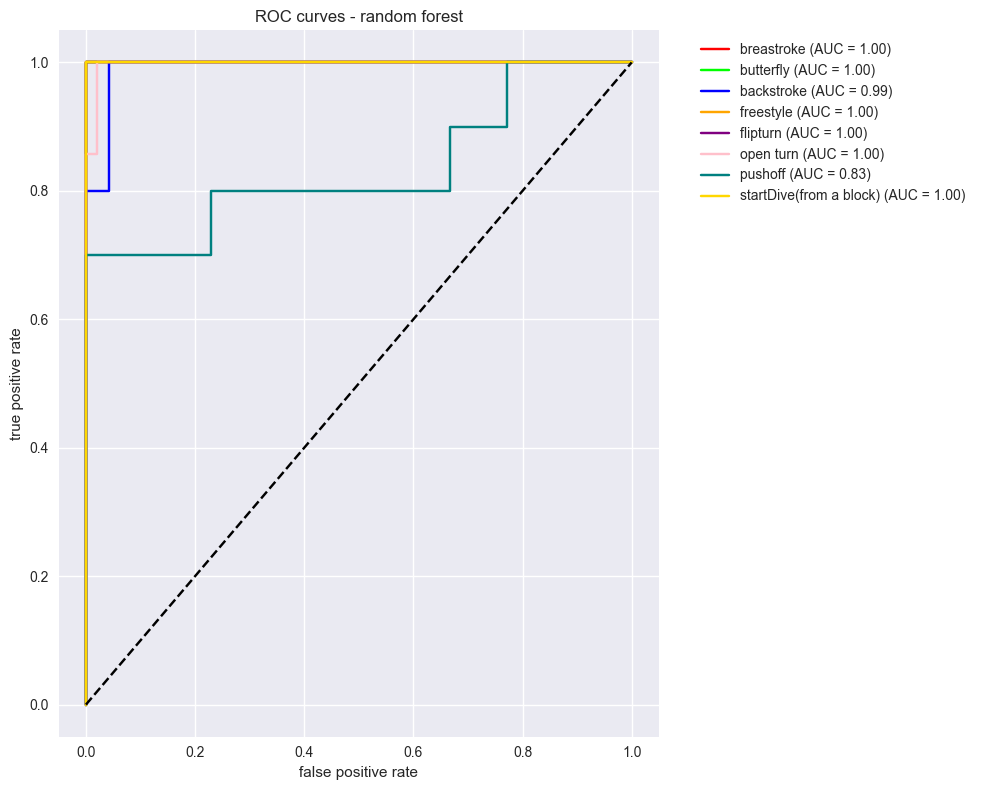


average AUC for random forest: 0.978


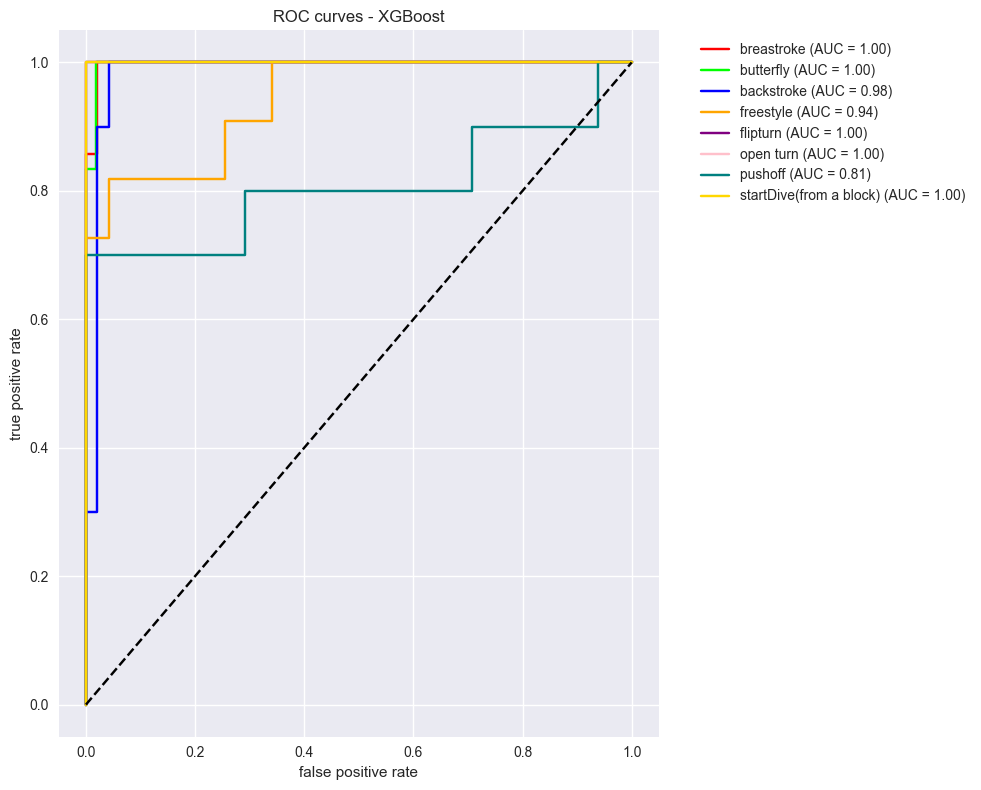


average AUC for XGBoost: 0.966


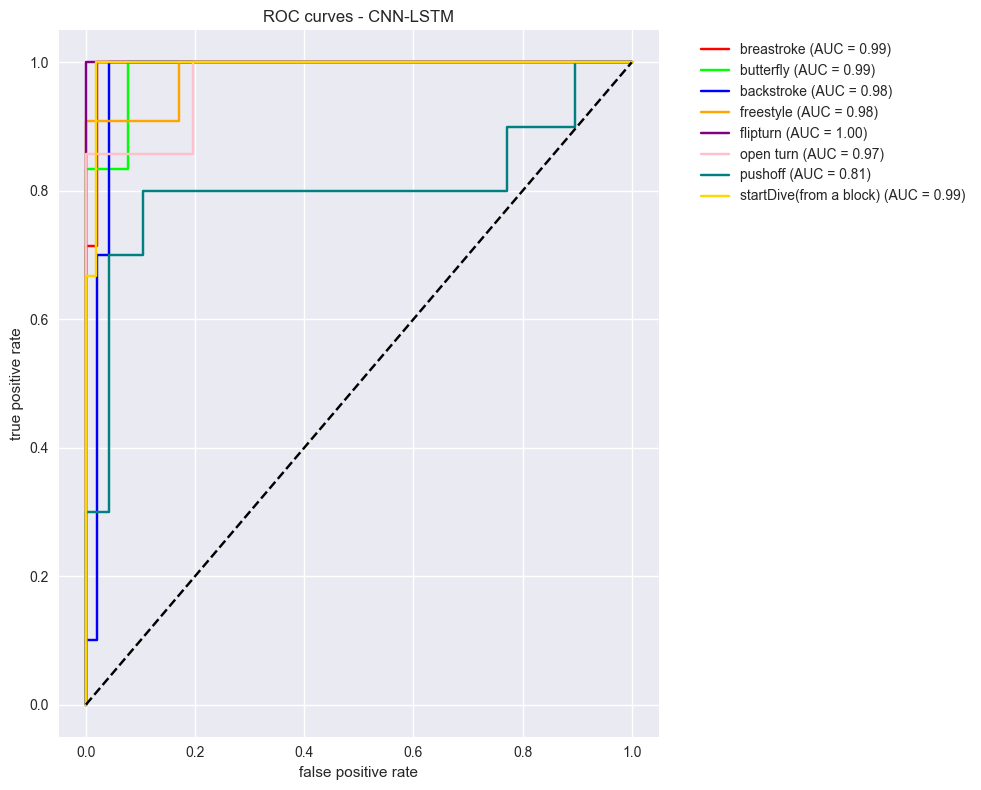


average AUC for CNN-LSTM: 0.964


In [77]:
def plot_roc_curves(y_true, y_pred_proba, model_name):
    """
    ROC curves for multiclass classification using predicted probabilities done by one vs rest (OVR)
    """
    plt.figure(figsize=(10, 8))
    auc_values = []
    stroke_types = list(dict.fromkeys(label_mapping.values()))
    
    colors = [
        '#FF0000',  # red
        '#00FF00',  # green
        '#0000FF',  # blue
        '#FFA500',  # orange
        '#800080',  # purple
        '#FFC0CB',  # pink
        '#008080',  # teal
        '#FFD700'   # gold
    ]
    
    for i, (class_name, color) in enumerate(zip(stroke_types, colors)):
        y_true_bin = (y_true == i).astype(int)
        y_score = y_pred_proba[:, i]
        
        fpr, tpr, _ = roc_curve(y_true_bin, y_score)
        roc_auc = auc(fpr, tpr)
        auc_values.append(roc_auc)
        
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})', color=color)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title(f'ROC curves - {model_name}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print(f'\naverage AUC for {model_name}: {np.mean(auc_values):.3f}')

# probability predictions (not class predictions)
lr_proba = lr.predict_proba(X_test_pca)   
rf_proba = best_rf.predict_proba(X_test_pca) 
xgb_proba = xgb.predict_proba(X_test_pca)
# already in prob
cnn_lstm_proba = test_pred  

plot_roc_curves(y_test_labels, lr_proba, 'logistic regression')
plot_roc_curves(y_test_labels, rf_proba, 'random forest')
plot_roc_curves(y_test_labels, xgb_proba, 'XGBoost')
plot_roc_curves(y_test_temporal.argmax(axis=1), cnn_lstm_proba, 'CNN-LSTM')

RandomForest classifier with RandomizedSearchCV and hyperparameter tuning that selected the best model based on cross validation achieved 0.9310 test accuracy compared to the deep learning model of a hybrid CNN-LSTM model, which reported a test accuracy of 0.8448. After evaluating all the models using AUC-ROC, the logistic regression model had the highest AUC at 0.979 compared to RandomForest 0.978 and CNN-LSTM 0.962.

For binary classification tasks (is it freestyle or not), Random Forest with a higher accuracy might be better but if the task requires probability estimates, which in this case does, then logistic regression might be better as it has the highest AUC. For classification problems, evaluating on AOC is preferable as it is more robust to class imbalance compared to just evaluating on accuracy.

However, the difference is small coming in at 0.2% so both models perform extremely well but I would go with the random forest model as the best performing overall when considering precision, recall, f1-score, accuracy, and confusion matrix as well